In [12]:
import requests, pandas as pd, numpy as np
from pandas import DataFrame
from io import StringIO
import time, json
from datetime import date
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = (15, 6)

In [55]:
df_fx_date = pd.read_csv('BOE-XUDLERD.csv')
df_fx_date.head()

,Date,Value
0,2017-11-09,0.8603
1,2017-11-08,0.8631
2,2017-11-07,0.8639
3,2017-11-06,0.8631
4,2017-11-03,0.8608


In [56]:
df_fx_date['Date'] = pd.to_datetime(df_fx_date.Date)
df_fx_date.set_index('Date', inplace=True)
df_fx_date.sort_index(inplace=True)
ts = df_fx_date['Value']

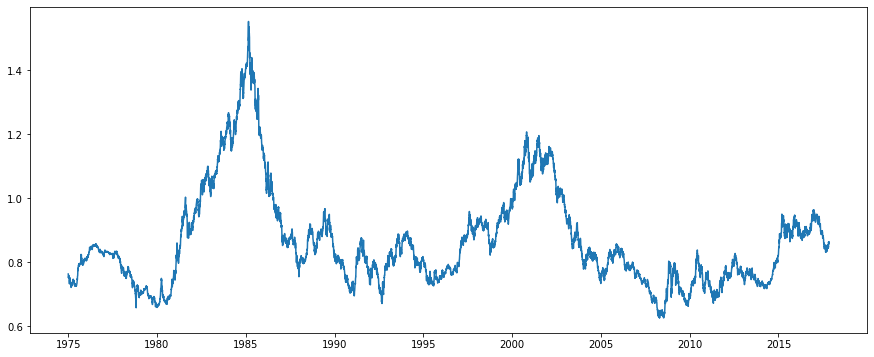

In [57]:
plt.plot(ts)

In [58]:
ts_week = ts.resample('W').mean()

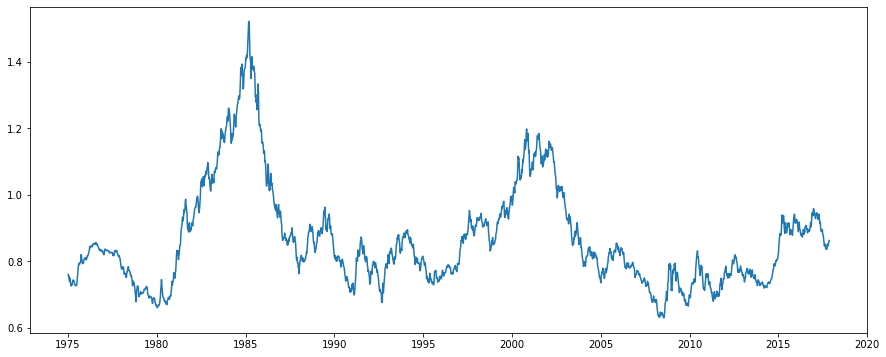

In [59]:
plt.plot(ts_week)

In [53]:
def test_stationarity(timeseries):
    rolmean = timeseries.rolling(window=52, center=False).mean()
    rolstd = timeseries.rolling(window=52, center=False).std()
    #Plot rolling statistics
    orig = plt.plot(timeseries, color='blue', label='Original Time Series Data')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Standard Deviation')
    plt.legend(loc='best')
    plt.title('Rolling Meand & Standard Deviation')
    plt.show(block=False)
    print('Results of Dickey-Fuller Test:\n')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistics', 'p-value' ,'#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput[f'Critical Value {key}'] = value
        
    
    print(dfoutput)

    

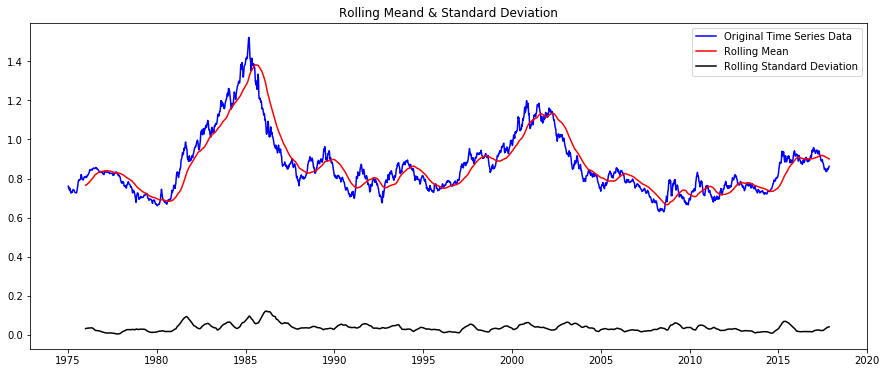

Results of Dickey-Fuller Test:

Test Statistics                  -2.076341
p-value                           0.254134
#Lags Used                        2.000000
Number of Observations Used    2234.000000
Critical Value 1%                -3.433281
Critical Value 5%                -2.862835
Critical Value 10%               -2.567459
dtype: float64


In [60]:
test_stationarity(ts_week)

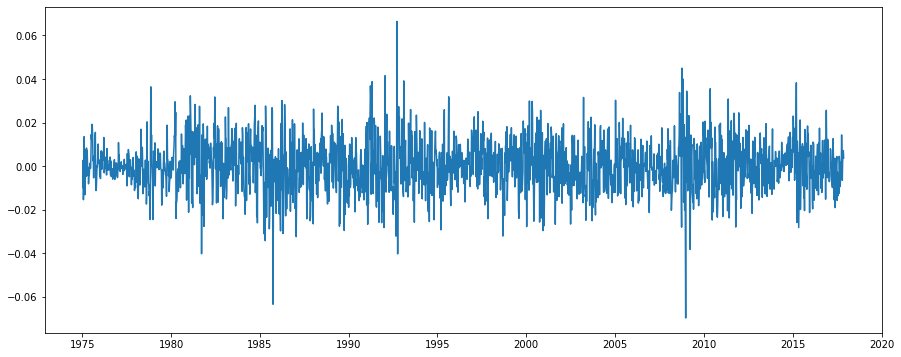

In [61]:
ts_week_log = np.log(ts_week)
ts_week_log_diff = ts_week_log - ts_week_log.shift()
plt.plot(ts_week_log_diff)

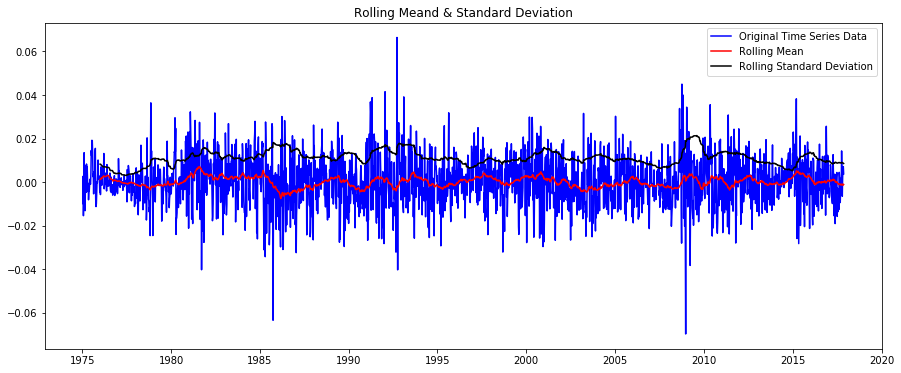

Results of Dickey-Fuller Test:

Test Statistics                 -36.590004
p-value                           0.000000
#Lags Used                        0.000000
Number of Observations Used    2235.000000
Critical Value 1%                -3.433279
Critical Value 5%                -2.862834
Critical Value 10%               -2.567459
dtype: float64


In [62]:
ts_week_log_diff.dropna(inplace=True)
test_stationarity(ts_week_log_diff)

In [63]:
# ACF and PACF
lag_acf = acf(ts_week_log_diff, nlags=10)
lag_pacf = pacf(ts_week_log_diff, nlags=10, method='ols')

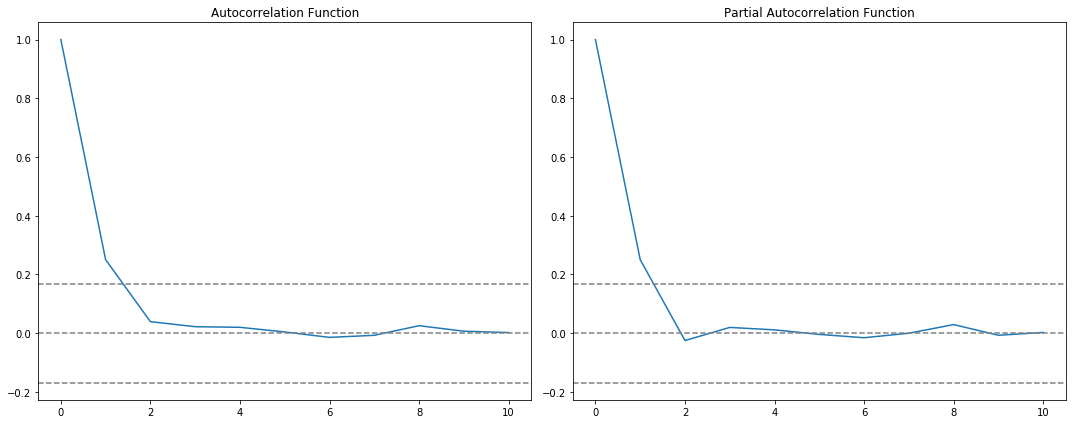

In [66]:
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-7.96/np.sqrt(len(ts_week_log_diff)), linestyle='--', color='gray')
plt.axhline(y=7.96/np.sqrt(len(ts_week_log_diff)), linestyle='--', color='gray')
plt.title('Autocorrelation Function')

plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-7.96/np.sqrt(len(ts_week_log_diff)), linestyle='--', color='gray')
plt.axhline(y=7.96/np.sqrt(len(ts_week_log_diff)), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

Text(0.5, 1.0, 'RSS: 0.2806')

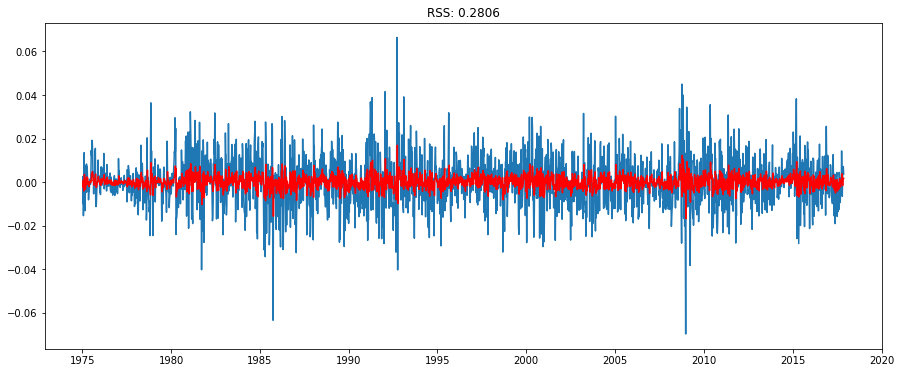

In [70]:
model = ARIMA(ts_week_log, order=(2,1,1))
results_ARIMA = model.fit(disp=-1)
plt.plot(ts_week_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title(f'RSS: {round(sum((results_ARIMA.fittedvalues - ts_week_log_diff)**2),4)}')

                             ARIMA Model Results                              
Dep. Variable:                D.Value   No. Observations:                 2236
Model:                 ARIMA(2, 1, 1)   Log Likelihood                6870.601
Method:                       css-mle   S.D. of innovations              0.011
Date:                Fri, 27 Sep 2019   AIC                         -13731.202
Time:                        22:50:25   BIC                         -13702.640
Sample:                    01-12-1975   HQIC                        -13720.773
                         - 11-12-2017                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const           5.51e-05      0.000      0.178      0.859      -0.001       0.001
ar.L1.D.Value    -0.0901      0.487     -0.185      0.853      -1.044       0.864
ar.L2.D.Value     0.0602      0.128     

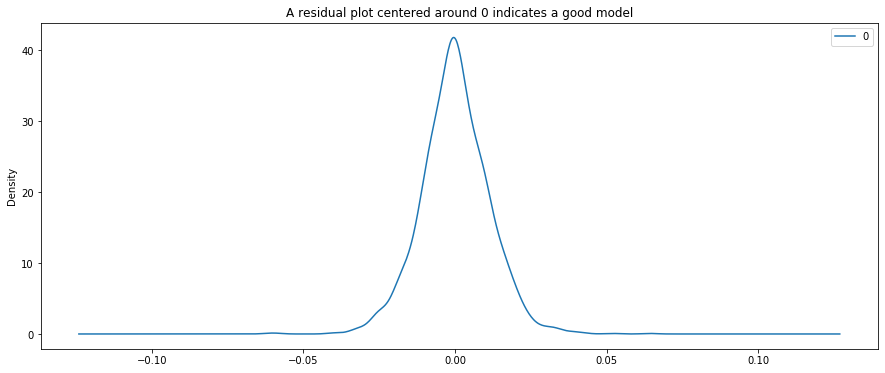

In [72]:
print(results_ARIMA.summary())
# plot residual errors
residuals = DataFrame(results_ARIMA.resid)
residuals.plot(kind='kde')
plt.title('A residual plot centered around 0 indicates a good model')
print(residuals.describe())

In [73]:
# Predictions
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print(predictions_ARIMA_diff.head())

Date
1975-01-12    0.000055
1975-01-19   -0.002420
1975-01-26    0.000987
1975-02-02   -0.004103
1975-02-09   -0.001134
Freq: W-SUN, dtype: float64


Text(0.5, 1.0, 'RMSE: 0.1353')

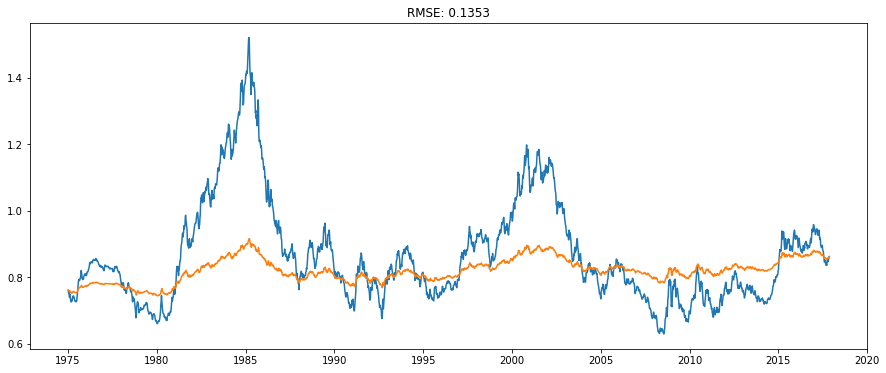

In [78]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_log = pd.Series(ts_week_log.iloc[0], index=ts_week_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(ts_week)
plt.plot(predictions_ARIMA)
plt.title(f'RMSE: {round(np.sqrt(sum((predictions_ARIMA-ts_week)**2)/len(ts_week)),4)}')
# The RMSE is close enough to 0, so the model predictions are accurate

In [83]:
# Training and Testing Datasets
size = int(len(ts_week_log) -15)
train, test = ts_week_log[0: size], ts_week_log[size: len(ts_week_log)]
history = [x for x in train]
predictions = list()
print('Printing Predicted vs Expected Values...\n')

for t in range(len(test)):
    model = ARIMA(history, order=(2,1,1))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(float(yhat))
    obs = test[t]
    history.append(obs)
    print(f'Predicted= {np.exp(yhat)}, expected= {round(np.exp(obs), 4)} ')

Printing Predicted vs Expected Values...

Predicted= [0.85545892], expected= 0.8462 
Predicted= [0.84362759], expected= 0.85 
Predicted= [0.85129876], expected= 0.8518 
Predicted= [0.85206231], expected= 0.8465 
Predicted= [0.84514685], expected= 0.8385 
Predicted= [0.83666553], expected= 0.8362 
Predicted= [0.83578104], expected= 0.8376 
Predicted= [0.83804973], expected= 0.8359 
Predicted= [0.83538368], expected= 0.8479 
Predicted= [0.85112559], expected= 0.8518 
Predicted= [0.8524885], expected= 0.8463 
Predicted= [0.84490639], expected= 0.848 
Predicted= [0.848604], expected= 0.8533 
Predicted= [0.85455175], expected= 0.8594 
Predicted= [0.86085273], expected= 0.8626 


In [88]:
error = mean_squared_error(test, predictions)
print('Printing Mean Squared Error of Predictions...')
print('Test MSE: %.6f' %error)
predictions_series = pd.Series(predictions, index=test.index)

Printing Mean Squared Error of Predictions...
Test MSE: 0.000043


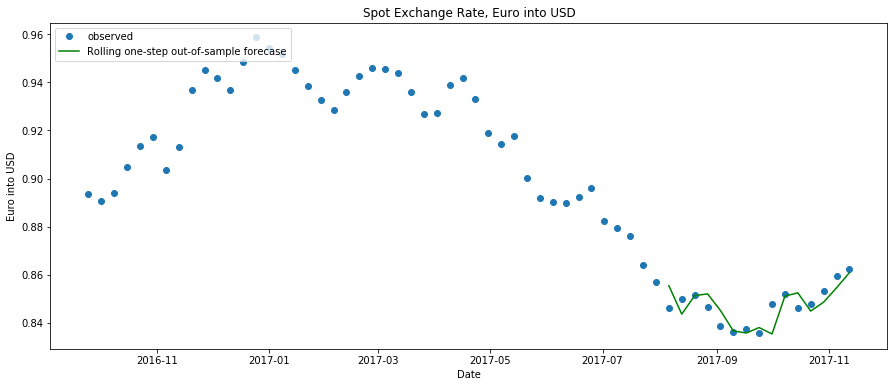

In [89]:
fig, ax = plt.subplots()
ax.set(title='Spot Exchange Rate, Euro into USD', xlabel='Date', ylabel='Euro into USD')
ax.plot(ts_week[-60:], 'o', label='observed')
ax.plot(np.exp(predictions_series), 'g', label='Rolling one-step out-of-sample forecase')
legend = ax.legend(loc='upper left')
legend.get_frame().set_facecolor('w')